In [ ]:
!pip install mip

     |████████████████████████████████| 47.1MB 77kB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.optimize import linprog
from copy import deepcopy
import time
import seaborn as sns
import pandas as pd

from itertools import product
from sys import stdout as out
from mip import Model, xsum, minimize, BINARY

# Helper function

In [ ]:
# DOUBLE CHEKC THIS LATER!!! MAYBE CHANGE TO NETWORKX 
def find_sortest_route(c, V, places):
    model = Model()

    # binary variables indicating if arc (i,j) is used on the route or not
    x = [[model.add_var(var_type=BINARY) for j in V] for i in V]

    # continuous variable to prevent subtours: each city will have a
    # different sequential id in the planned route except the first one
    y = [model.add_var() for i in V]

    # objective function: minimize the distance
    model.objective = minimize(xsum(c[i][j]*x[i][j] for i in V for j in V))

    # constraint : leave each city only once
    for i in V:
        model += xsum(x[i][j] for j in V - {i}) == 1

    # constraint : enter each city only once
    for i in V:
        model += xsum(x[j][i] for j in V - {i}) == 1

    # subtour elimination
    for (i, j) in product(V - {0}, V - {0}):
        if i != j:
            model += y[i] - (n+1)*x[i][j] >= y[j]-n

    # optimizing
    model.optimize()

    # checking if a solution was found
    if model.num_solutions:
        out.write('route with total distance %g found: %s'
                % (model.objective_value, places[0]))
        nc = 0
        while True:
            nc = [i for i in V if x[nc][i].x >= 0.99][0]
            out.write(' -> %s' % places[nc])
            if nc == 0:
                break
        out.write('\n')

In [ ]:
def branch_bound_OLD(problem, prunning=True, best_first_search=True):
    # initial solution to the relaxed problem (root node)
    res = linprog(**problem)

    queue = [problem]
    z = np.inf
    solution = 0
    i = 0
    problem['label'] = 0
    tree = []
    built_nodes = 1
    while len(queue) != 0:
        problem = queue.pop(0)
        tree.append(problem)
        #print(problem)
        res = linprog(**{key:value for key, value in problem.items() if key != 'label'})
        
        if res.status != 2: # is feasible
            if all([np.isclose(x, np.round(x)) for x in res.x]): # integrality check
                if res.fun < z:
                    solution = res
                    z = res.fun
            else:
                best_value = np.inf
                if prunning:
                    best_value = z
                if res.fun < best_value:
                    bfs_solutions = [] # hold the solutions to reorder in BFS
                    for idx, x in enumerate(res.x):
                        if not np.isclose(x, np.round(x)):
                            problem2 = deepcopy(problem)
                            problem2['bounds'][idx][1] = int(x) # left
                            problem2['label'] = problem['label']+1
                            
                            problem3 = deepcopy(problem)
                            problem3['bounds'][idx][0] = int(x)+1 # right
                            problem3['label'] = problem['label']+1
                            
                            built_nodes += 2
                            
                            if best_first_search:
                                res2 = linprog(**{key:value for key, value in problem2.items() if key != 'label'})
                                res3 = linprog(**{key:value for key, value in problem3.items() if key != 'label'})
                                bfs_solutions.append((res2, problem2))
                                bfs_solutions.append((res3,problem3))
                                '''
                                if res2.fun < res3.fun:
                                    queue.append(problem2)
                                    queue.append(problem3)
                                    res = res2
                                else:
                                    queue.append(problem3)
                                    queue.append(problem2)
                                    res = res3
                                '''
                            else:
                                queue.append(problem2)
                                queue.append(problem3)

                            break
                    if best_first_search:
                        # reorder the solution in bfs_solutions and extend the queue in the correct order
                        bfs_solutions = sorted(bfs_solutions, key= lambda tuple_: tuple_[0].fun)
                        bfs_solutions = [tuple_[1] for tuple_ in bfs_solutions]
                        queue.extend(bfs_solutions)
                                
            
    #print(z)
    #print(tree)
    
    #print(solution)
    return solution, tree, built_nodes

In [ ]:
def branch_bound(problem, prunning=True, best_first_search=True):
    # initial solution to the relaxed problem (root node)
    res = linprog(**problem)

    queue = [(problem, res)]
    z = np.inf
    solution = 0
    i = 0
    problem['depth'] = 0
    problem['label'] = 0
    tree = []
    edge_list = []
    unique_labels = [0]

    #built_nodes = 1
    while len(queue) != 0:
        problem, res = queue.pop(0)
        tree.append(problem)
        #print(problem)
        
        if res.status != 2: # is feasible
            if all([np.isclose(x, np.round(x)) for x in res.x]): # integrality check
                if res.fun < z:
                    solution = res
                    z = res.fun
            else:
                best_value = np.inf
                if prunning:
                    best_value = z
                if res.fun < best_value:
                    for idx, x in enumerate(res.x):
                        if not np.isclose(x, np.round(x)):
                            problem2 = deepcopy(problem)
                            problem2['bounds'][idx][1] = int(x) # left
                            problem2['depth'] = problem['depth']+1
                            problem2['label'] = unique_labels[-1] + 1
                            
                            problem3 = deepcopy(problem)
                            problem3['bounds'][idx][0] = int(x)+1 # right
                            problem3['depth'] = problem['depth']+1
                            problem3['label'] = unique_labels[-1] + 2

                            unique_labels.append(problem2['label'])
                            unique_labels.append(problem3['label'])
                            
                            edge_list.append((problem['label'],problem2['label']))
                            edge_list.append((problem['label'],problem3['label']))
                            #built_nodes += 2
                            
                            
                            
                            res2 = linprog(**{key:value for key, value in problem2.items() if key not in ['depth','label']})
                            res3 = linprog(**{key:value for key, value in problem3.items() if key not in ['depth','label']})
                            
                            if res2.status != 2:
                                queue.append((problem2, res2))
                                
                            if res3.status != 2:
                                queue.append((problem3, res3))
                                
                            if best_first_search:
                                queue = sorted(queue, key = lambda tup_: tup_[1].fun)    
                            break
                            
                        
                                
            
    #print(z)
    #print(tree)
    
    #print(solution)
    return solution, tree, edge_list

In [ ]:
def optimize_route(parameters_problem, parameters_tourist, prunning=True, best_first_search=True, verbose=False):
    '''
    parameters_problem ={
                    # level of preference (satisfaction) of each touristic place (maybe taken from previous tourist with similar profile?)
                    'preference_attraction': [10, 13, 18, 31, 7, 15, 10],
                    # cost of visiting each place 
                    'cost_attraction': [11, 15, 20, 35, 10, 33, 0],
                    # time (recommended) to visit each place
                    'time_attraction': [1.1, 1.5, 2.0, 3.5, 1.0, 3.3, 5],
                    # type of attraction (0-cultural, 1-nature)
                    'type_of_attraction': [0, 0, 0, 0, 0, 0, 1]
    }

    parameters_tourist = {
                    # budget is the tourist budget
                    'budget':47,
                    # t_tot is the total available time of the tourist
                    'time_available':8,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': 0,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 3
    }
    '''
    # Step 1 - remove the points which are not according pref
    parameters_problem_new = {key:[] for key in parameters_problem}
    if not np.isinf(parameters_tourist['preference']):
        for key in parameters_problem_new:
            for idx, value in enumerate(parameters_problem[key]):
                if parameters_problem['type_of_attraction'][idx] == parameters_tourist['preference']:
                    parameters_problem_new[key].append(value)
    else:
        for key in parameters_problem_new:
            for idx, value in enumerate(parameters_problem[key]):
                parameters_problem_new[key].append(value)


    # number of variables
    I = range(len(parameters_problem_new['preference_attraction']))

    # binary restriction for 0- not visit the place or 1-visit the place
    bounds = [[0, 1]for i in I]

    # penalize for visiting less than num_places places
    num_places = parameters_tourist['num_places']
    
    ## --------CONSTRAINTS --------------------------
    w = parameters_problem_new['cost_attraction']
    b = parameters_tourist['budget']
    

    t = parameters_problem_new['time_attraction']
    t_tot = parameters_tourist['time_available']
    
    ## --------PROBLEM DEFINITION --------------------------
    # preference must be multiplied by -1 because it is configured as a minimization problem
    lambda_ = 10.0 # NOT USING THIS FOR NOW
    c = [i*(-1) for i in parameters_problem_new['preference_attraction']]
    # upper bound - costs of attractions (w) and the time required for each attraction (t)
    A_ub = []
    if not np.isinf(b):
        A_ub.append(w)
    else:
        A_ub.append([0 for i in I])
    
    if not np.isinf(t_tot):
        A_ub.append(t)
    else:
        A_ub.append([0 for i in I])

    # limit on tourist budget (c) and time available (t_tot)
    b_ub = []
    if not np.isinf(b):
        b_ub.append(b)
    else:
        b_ub.append(1)

    if not np.isinf(t_tot):
        b_ub.append(t_tot)
    else:
        b_ub.append(1)
    

    problem = {'c':c, 'A_ub':A_ub, 'b_ub':b_ub, 'bounds':bounds}
    
    # solve the MIP (mixed integer problem) using Branch and Bound with the proper
    # heuristics
    
    solution, tree, built_nodes = branch_bound(problem , prunning, best_first_search)
    
    x = np.where(solution.x>=0.99,1,0)
    
    selected = [i for i in I if x[i] >= 0.99]
    solution = {'selected': selected,
                'satisfaction': sum([parameters_problem_new['preference_attraction'][i] for i in selected]),
                'money_spent': sum([w[i]*x[i] for i in selected]),
                'time_spent': sum([t[i]*x[i] for i in selected])}
    

    if verbose:
        print("selected places to visit: {}".format(solution['selected']))
        print("level of satisfaction: {}".format(solution['satisfaction']))
        print("money spent: {}".format(solution['money_spent']))
        print("time spent: {}".format(solution['time_spent']))

    return solution, tree, built_nodes

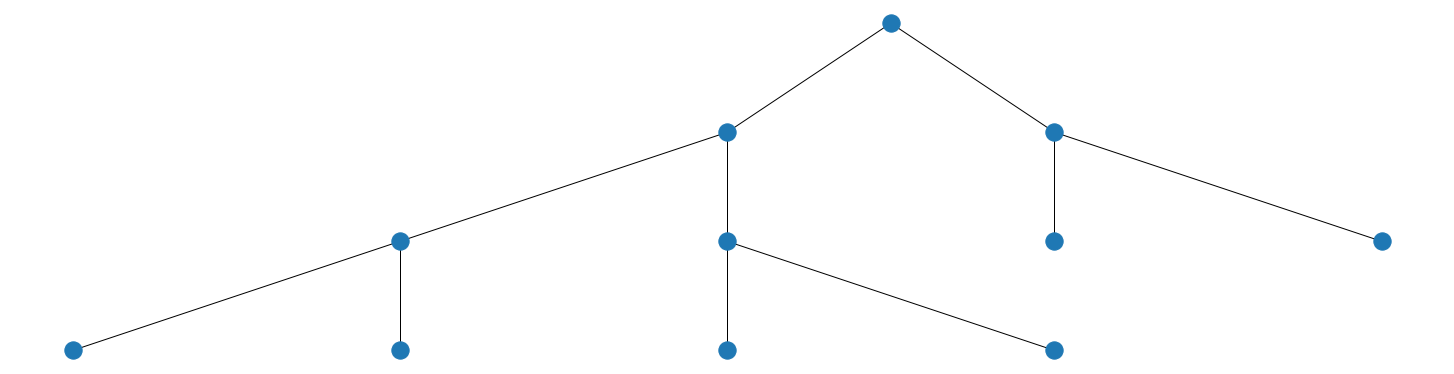

In [ ]:
## test draw tree
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

edges = [(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (4, 9), (4, 10)]
G1 = nx.Graph()
G1.add_edges_from(edges)

plt.figure(figsize = (20,5))
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)
plt.show()

# Case 1 - Academic

## Structure

In [ ]:
# names of places to visit
places = ['A', 'B', 'C', 'D', 'E','F','G']

# distances in an upper triangular matrix
dists = [[5, 17, 20, 25, 1, 10],
         [10, 15, 19, 30, 15],
         [1, 8, 19, 7],
         [5, 20, 12],
         [10, 15],
         [13],
         []]

# tourist wants to visit all places maximizing his satisfaction, while satisfying his budget
parameters_problem ={
                    # level of preference (satisfaction) of each touristic place (maybe taken from previous tourist with similar profile?)
                    'preference_attraction': [ 1.,  2.,  5., 10.,  0.,  3.,  5.], #[10, 13, 18, 31, 7, 15, 20],
                    # cost of visiting each place 
                    'cost_attraction': [11, 15, 20, 35, 10, 33, 0],
                    # time (recommended) to visit each place
                    'time_attraction': [1.1, 1.5, 2.0, 3.5, 1.0, 3.3, 1],
                    # type of attraction (0-cultural, 1-nature)
                    'type_of_attraction': [0, 0, 0, 0, 0, 0, 1]
}

# number of nodes and list of vertices
n, V = len(dists), set(range(len(dists)))

# distances matrix
c = [[0 if i == j
      else dists[i][j-i-1] if j > i
      else dists[j][i-j-1]
      for j in V] for i in V]

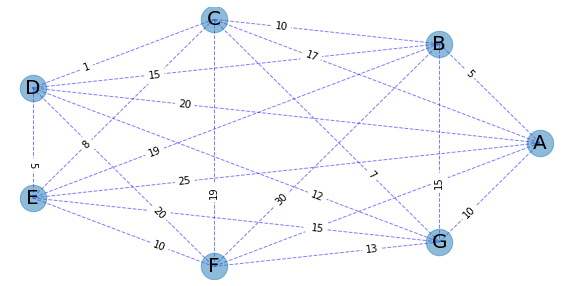

In [ ]:
plt.figure(figsize = (10,5))
G = nx.from_numpy_matrix(np.array(c))
G = nx.relabel_nodes(G, {i:places[i] for i in range(len(places))})

pos = nx.circular_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700, alpha=0.5)

labels = nx.get_edge_attributes(G,'weight')

# edges
nx.draw_networkx_edges(
    G, pos, width=1.0, alpha=0.5, edge_color="b", style="dashed"
)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,label_pos=0.3)

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

plt.axis("off")
plt.show()

## Finding the shortest route - no constraint at all except visit each point only once

In [ ]:
find_sortest_route(c, V,places)

route with total distance 44 found: A -> B -> G -> C -> D -> E -> F -> A


## Optimize the route, eliminating places which are not of interest and satisfy budget and time available

### No constraint on time, budget or kind of route - the result should be all the touristic points selected

In [ ]:
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':np.inf,
                    # t_tot is the total available time of the tourist
                    'time_available':np.inf,
                    # preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places preferred (minimum) number of places to visit
                    'num_places': 0
}

In [ ]:
solution, tree, edge_list = optimize_route(parameters_problem, parameters_tourist, prunning=False, best_first_search=False, verbose=False)

In [ ]:
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)

depth =  0
n nodes =  1
--------------------


### Constrain the budget

In [ ]:
# NO HEURISTICS
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':80,
                    # t_tot is the total available time of the tourist
                    'time_available':np.inf,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 0
}

solution, tree, edge_list_simple = optimize_route(parameters_problem, parameters_tourist, prunning= False, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
solution, tree, edge_list_prunning = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
solution, tree, edge_list_bfs = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=True, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))

selected places to visit: [1, 2, 3, 6]
level of satisfaction: 22.0
money spent: 70
time spent: 8.0
depth =  6
n nodes =  46
--------------------
selected places to visit: [1, 2, 3, 6]
level of satisfaction: 22.0
money spent: 70
time spent: 8.0
depth =  4
n nodes =  16
--------------------
selected places to visit: [1, 2, 3, 6]
level of satisfaction: 22.0
money spent: 70
time spent: 8.0
depth =  4
n nodes =  14


In [ ]:


#find_sortest_route(c, V,places)

array([0, 0, 0, 0])

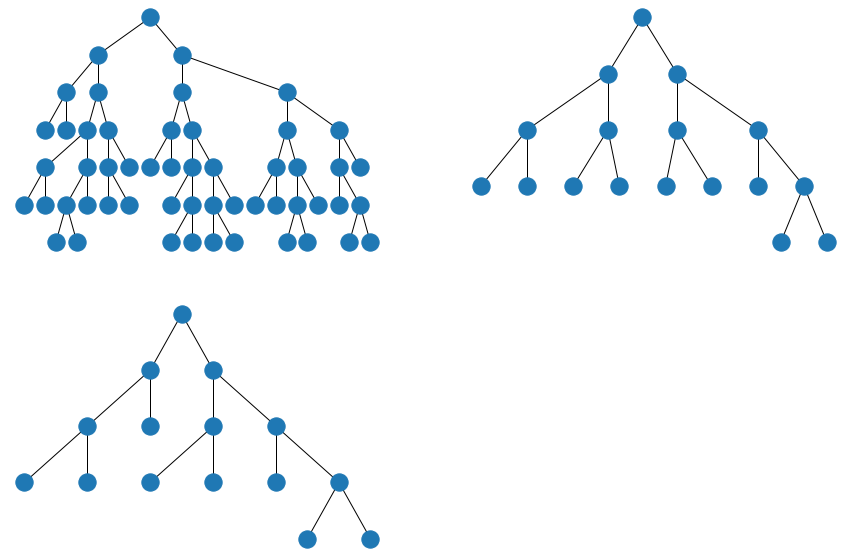

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
G1 = nx.Graph()
G1.add_edges_from(edge_list_simple)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.subplot(2,2,2)
G1 = nx.Graph()
G1.add_edges_from(edge_list_prunning)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.subplot(2,2,3)
G1 = nx.Graph()
G1.add_edges_from(edge_list_bfs)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.show()

In [ ]:
from tqdm import tqdm
exec_time_simple = []
for i in tqdm(range(100)):
    start = time.time()
    solution, tree, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= False, best_first_search=False, verbose = False)
    end = time.time()
    exec_time_simple.append(end-start)

print('Simple complete')
exec_time_prunning = []
for i in tqdm(range(100)):
    start = time.time()
    solution, tree, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=False, verbose = False)
    end = time.time()
    exec_time_prunning.append(end-start)

print('Prune complete')
exec_time_bfs = []
for i in tqdm(range(100)):
    start = time.time()
    solution, tree, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=True, verbose = False)
    end = time.time()
    exec_time_bfs.append(end-start)

  1%|          | 1/100 [00:00<00:10,  9.05it/s]

Simple complete


  2%|▏         | 2/100 [00:00<00:07, 13.04it/s]

Prune complete


100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

       no heuristics    prunning         bfs
count     100.000000  100.000000  100.000000
mean        0.161535    0.113017    0.075762
std         0.009585    0.005397    0.004283
min         0.153309    0.106478    0.070611
25%         0.155932    0.109480    0.072161
50%         0.157969    0.110973    0.075431
75%         0.162611    0.115217    0.077535
max         0.200453    0.136680    0.095092


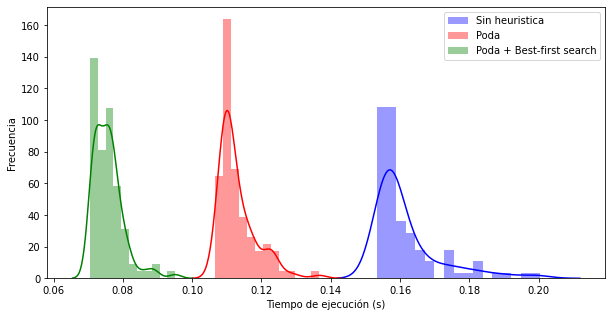

In [ ]:
df = pd.DataFrame({'no heuristics': exec_time_simple, 'prunning': exec_time_prunning, 'bfs': exec_time_bfs})
 
# Method 1: on the same Axis
plt.figure(figsize=(10,5))
sns.distplot( df["no heuristics"] , color="blue", label="Sin heuristica")
sns.distplot( df["prunning"] , color="red", label="Poda")
sns.distplot( df["bfs"] , color="green", label="Poda + Best-first search")
plt.legend()
plt.xlabel('Tiempo de ejecución (s)')
plt.ylabel('Frecuencia')

print(df.describe())


In [ ]:
budgets = [0,20,40,60,80,100]

results = {'budget':[],
              'number nodes simple':[], 'number nodes prunning':[], 'number nodes BFS':[],
              'depth simple':[], 'depth prunning':[], 'depth BFS':[]}

for budget in budgets:
    parameters_tourist['budget'] = budget
    solution, tree_simple, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= False, best_first_search=False, verbose=False)
    solution, tree_prunning, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=False, verbose=False)
    solution, tree_bfs, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=True, verbose=False)
    
    results['budget'].append(budget)
    results['number nodes simple'].append(len(tree_simple))
    results['number nodes prunning'].append(len(tree_prunning))
    results['number nodes BFS'].append(len(tree_bfs))

    results['depth simple'].append(tree_simple[-1]['depth'])
    results['depth prunning'].append(tree_prunning[-1]['depth'])
    results['depth BFS'].append(tree_bfs[-1]['depth'])

pd.DataFrame(results)




,budget,number nodes simple,number nodes prunning,number nodes BFS,depth simple,depth prunning,depth BFS
0,0,1,1,1,0,0,0
1,20,2,2,2,1,1,1
2,40,37,27,12,6,5,4
3,60,53,25,9,6,4,3
4,80,46,16,14,6,4,4
5,100,37,22,16,6,5,5


### All constraints except preference on kind



In [ ]:
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':80,
                    # t_tot is the total available time of the tourist
                    'time_available':7,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 0
}

tree, edge_list_simple = optimize_route(parameters_problem, parameters_tourist, prunning= False, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
tree, edge_list_prunning = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
tree, edge_list_bfs = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=True, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))

selected places to visit: [2, 3, 6]
level of satisfaction: 20.0
money spent: 55
time spent: 6.5
depth =  7
n nodes =  78
--------------------
selected places to visit: [2, 3, 6]
level of satisfaction: 20.0
money spent: 55
time spent: 6.5
depth =  4
n nodes =  29
--------------------
selected places to visit: [2, 3, 6]
level of satisfaction: 20.0
money spent: 55
time spent: 6.5
depth =  3
n nodes =  9


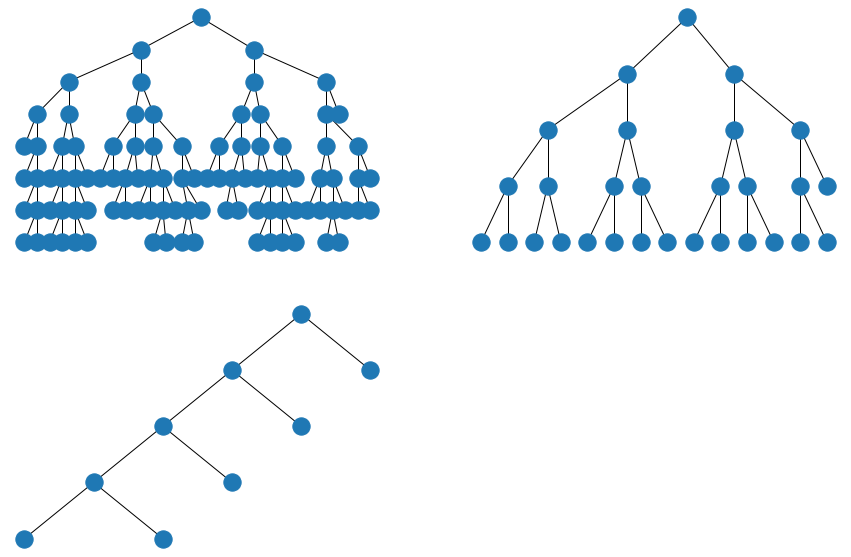

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
G1 = nx.Graph()
G1.add_edges_from(edge_list_simple)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.subplot(2,2,2)
G1 = nx.Graph()
G1.add_edges_from(edge_list_prunning)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.subplot(2,2,3)
G1 = nx.Graph()
G1.add_edges_from(edge_list_bfs)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.show()

### All constraints plus preference on kind



In [ ]:
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':80,
                    # t_tot is the total available time of the tourist
                    'time_available':7,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': 0,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 0
}

tree, edge_list_simple = optimize_route(parameters_problem, parameters_tourist, prunning= False, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
tree, edge_list_prunning = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
tree, edge_list_bfs = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=True, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))

selected places to visit: [1, 2, 3]
level of satisfaction: 17.0
money spent: 70
time spent: 7.0
depth =  0
n nodes =  1
--------------------
selected places to visit: [1, 2, 3]
level of satisfaction: 17.0
money spent: 70
time spent: 7.0
depth =  0
n nodes =  1
--------------------
selected places to visit: [1, 2, 3]
level of satisfaction: 17.0
money spent: 70
time spent: 7.0
depth =  0
n nodes =  1


# Case 2 - Antigua Guatemala

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

## Preprocessing

In [ ]:
#wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/12mAtfRX3-2rbDS59mF2PAemRquq4b7dy5SurHRAha1A/edit#gid=1434767635')
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/12mAtfRX3-2rbDS59mF2PAemRquq4b7dy5SurHRAha1A/edit?usp=sharing')
hoja_puntos = wb.worksheet('Puntos de interes')
hoja_distancias = wb.worksheet('Distancias')
hoja_parametros = wb.worksheet('Parametros')

In [ ]:
data = hoja_puntos.get_all_values()
df_puntos = pd.DataFrame(data)

# la primera linea as header
df_puntos.columns = df_puntos.iloc[0]
df_puntos = df_puntos[1:]


df_puntos.head()

,Sitio,"Latitud, Longitud","Tipo (0-cultural, 1-natural)"
1,El Arco de Santa Catalina,"14.559576, -90.734262",0
2,Volcán Acatenango,"14.500461, -90.8756662",1
3,Volcán Pacaya,"14.3823075, -90.60150709999999",1
4,Mercado de Artesanias El Carmen,"14.5585534, -90.732288",0
5,Iglesia de La Merced Antigua Guatemala,"14.5612059, -90.7345734",0


In [ ]:
# Separar latitud y longitud
df_coords = df_puntos['Latitud, Longitud'].str.split(',', expand=True)
print(df_coords)
df_puntos['Latitud'] = df_coords.loc[:,0]
df_puntos['Longitud'] = df_coords.loc[:,1]

# remover coluna lat, long mezclado
df_puntos = df_puntos.drop(['Latitud, Longitud'], axis = 1)
df_puntos = df_puntos.set_index('Sitio', drop=True)
df_puntos.head()

             0                    1
1    14.559576           -90.734262
2    14.500461          -90.8756662
3   14.3823075   -90.60150709999999
4   14.5585534           -90.732288
5   14.5612059          -90.7345734
6   14.5568894          -90.7336838
7   14.5644444   -90.73166669999999
8   14.5535666          -90.7289438
9   14.5453185   -90.73454369999999
10   14.545775           -90.777204


,"Tipo (0-cultural, 1-natural)",Latitud,Longitud
Sitio,,,
El Arco de Santa Catalina,0,14.559576,-90.734262
Volcán Acatenango,1,14.500461,-90.8756662
Volcán Pacaya,1,14.3823075,-90.60150709999999
Mercado de Artesanias El Carmen,0,14.5585534,-90.732288
Iglesia de La Merced Antigua Guatemala,0,14.5612059,-90.7345734


In [ ]:
data = hoja_distancias.get_all_values()
df_dist = pd.DataFrame(data)

# la primera linea as header
df_dist.columns = df_dist.iloc[0]
df_dist = df_dist[1:]
df_dist = df_dist.set_index('', drop = True)

df_dist.head()

,El Arco de Santa Catalina,Volcán Acatenango,Volcán Pacaya,Mercado de Artesanias El Carmen,Iglesia de La Merced Antigua Guatemala,Parque Central Antigua Guatemala,Cerro de la Cruz Antigua Guatemala,Iglesia de San Francisco Antigua Guatemala,Granjas de Caoba,Museo Casa del Tejido
,,,,,,,,,,
El Arco de Santa Catalina,1 m,23.5 km,49.8 km,0.9 km,0.2 km,0.7 km,2.0 km,1.5 km,2.2 km,8.2 km
Acatenango Volcano,22.1 km,1 m,67.8 km,22.2 km,30.8 km,22.0 km,31.3 km,22.2 km,21.0 km,18.8 km
Volcán Pacay,46.9 km,67.6 km,1 m,46.6 km,47.0 km,46.8 km,48.6 km,47.2 km,35.3 km,58.7 km
Mercado de Artesanias El Carmen,0.8 km,23.9 km,49.4 km,1 m,0.5 km,0.7 km,2.0 km,1.1 km,2.2 km,8.5 km
Iglesia de La Merced Antigua Guatemala,0.4 km,23.4 km,49.7 km,0.8 km,1 m,0.5 km,1.8 km,1.4 km,2.0 km,8.0 km


In [ ]:
# remover km en las celdas y ponder 1m como 0 (el mismo punto)
df_dist = df_dist.replace({',':'','km':'', '1 m':0, '#ERROR!':np.nan}, regex= True).astype(float)
df_dist

,El Arco de Santa Catalina,Volcán Acatenango,Volcán Pacaya,Mercado de Artesanias El Carmen,Iglesia de La Merced Antigua Guatemala,Parque Central Antigua Guatemala,Cerro de la Cruz Antigua Guatemala,Iglesia de San Francisco Antigua Guatemala,Granjas de Caoba,Museo Casa del Tejido
,,,,,,,,,,
El Arco de Santa Catalina,0.0,23.5,49.8,0.9,0.2,0.7,2.0,1.5,2.2,8.2
Acatenango Volcano,22.1,0.0,67.8,22.2,30.8,22.0,31.3,22.2,21.0,18.8
Volcán Pacay,46.9,67.6,0.0,46.6,47.0,46.8,48.6,47.2,35.3,58.7
Mercado de Artesanias El Carmen,0.8,23.9,49.4,0.0,0.5,0.7,2.0,1.1,2.2,8.5
Iglesia de La Merced Antigua Guatemala,0.4,23.4,49.7,0.8,0.0,0.5,1.8,1.4,2.0,8.0
Parque Central Antigua Guatemala,0.5,23.2,49.8,0.7,0.7,0.0,2.7,0.8,1.5,7.8
Cerro de la Cruz Antigua Guatemala,1.8,31.3,51.2,2.3,1.5,2.1,0.0,2.9,3.6,9.6
Iglesia de san francisco Antigua Guatemala,1.3,23.3,49.2,1.0,1.5,1.2,3.0,0.0,1.6,7.9
Granjas de Caoba,1.7,22.2,50.6,1.8,1.8,1.6,3.8,1.4,0.0,6.8


In [ ]:
df_dist = df_dist.fillna(df_dist.mean())
df_dist

,El Arco de Santa Catalina,Volcán Acatenango,Volcán Pacaya,Mercado de Artesanias El Carmen,Iglesia de La Merced Antigua Guatemala,Parque Central Antigua Guatemala,Cerro de la Cruz Antigua Guatemala,Iglesia de San Francisco Antigua Guatemala,Granjas de Caoba,Museo Casa del Tejido
,,,,,,,,,,
El Arco de Santa Catalina,0.0,23.5,49.8,0.9,0.2,0.7,2.0,1.5,2.2,8.2
Acatenango Volcano,22.1,0.0,67.8,22.2,30.8,22.0,31.3,22.2,21.0,18.8
Volcán Pacay,46.9,67.6,0.0,46.6,47.0,46.8,48.6,47.2,35.3,58.7
Mercado de Artesanias El Carmen,0.8,23.9,49.4,0.0,0.5,0.7,2.0,1.1,2.2,8.5
Iglesia de La Merced Antigua Guatemala,0.4,23.4,49.7,0.8,0.0,0.5,1.8,1.4,2.0,8.0
Parque Central Antigua Guatemala,0.5,23.2,49.8,0.7,0.7,0.0,2.7,0.8,1.5,7.8
Cerro de la Cruz Antigua Guatemala,1.8,31.3,51.2,2.3,1.5,2.1,0.0,2.9,3.6,9.6
Iglesia de san francisco Antigua Guatemala,1.3,23.3,49.2,1.0,1.5,1.2,3.0,0.0,1.6,7.9
Granjas de Caoba,1.7,22.2,50.6,1.8,1.8,1.6,3.8,1.4,0.0,6.8


In [ ]:
data = hoja_parametros.get_all_values()
df_parametros = pd.DataFrame(data)
df_parametros.columns = df_parametros.loc[0,:]
df_parametros = df_parametros.drop(0)
for column in ['Satisfaccion', 'Costo (USD)', 'Tiempo de visita (estimado)']:
    df_parametros[column] = df_parametros[column].astype(float)

df_parametros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 10
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Atraccion                    10 non-null     object 
 1   Satisfaccion                 10 non-null     float64
 2   Fuente (satisf)              10 non-null     object 
 3   Costo (USD)                  10 non-null     float64
 4   Costo (GTQ)                  10 non-null     object 
 5   Fuente (costo)               10 non-null     object 
 6   Tiempo de visita (estimado)  10 non-null     float64
dtypes: float64(3), object(4)
memory usage: 640.0+ bytes


## Structure

Estimar el costo
Tomamos el precio de la gasolina por litro (Guatemala) en https://es.globalpetrolprices.com
+ 0.728 USD/L

Estimaos el costo de cada atraccion por:
+ el sitio online
+ si no tiene precio en el primero, tripadvisor.es

| Atraccion |Satisfaccion| Fuente (satisf) | Costo (USD)| Fuente (costo)| Tiempo|
|----|----|-----|----|----|-----|
|El Arco de Santa Catalina|4.7|maps.google.com| 0 ||0.5|
|Acatenango Volcan|4.6|maps.google.com|80 (620GTQ) |tripadvisor.es |6|
|Volcán Pacay|4.5|maps.google.com|25.74 (200GTQ) |http://www.volcanpacaya.info/281291923|1|
|Mercado de Artesanias El Carmen|4.6|maps.google.com|0||2|
|Iglesia de La Merced Antigua Guatemala|4.7|""|0||0.5|
|Parque Central Antigua Guatemala|4.6|maps.google.com|0||1.5|
|Cerro de la Cruz Antigua Guatemala|4.6|maps.google.com|0||1|
|Iglesia de san francisco Antigua Guatemala|4.8|maps.google.com|0||0.5|
|Granjas de Caoba|4.5|maps.google.com| 8.37 (65GTQ)|www.caobafarms.com|2.3|
|Museo Casa del Tejido|4.7|maps.google.com|6.43 (50GTQ)|guatemala.com|1.5|

In [ ]:
# names of places to visit
places = df_dist.columns

# tourist wants to visit all places maximizing his satisfaction, while satisfying his budget
# preferences from google maps
# cost attraction de el sitio online de cada atracion (considera el costo aproximado de transporte)
# 0.728 USD/L de gasolina
# time_attraction es estimado
parameters_problem ={
                    # level of preference (satisfaction) of each touristic place (maybe taken from previous tourist with similar profile?)
                    'preference_attraction': df_parametros['Satisfaccion'].values,
                    # cost of visiting each place 
                    'cost_attraction': df_parametros['Costo (USD)'].values,
                    # time (recommended) to visit each place
                    'time_attraction': df_parametros['Tiempo de visita (estimado)'].values,
                    # type of attraction (0-cultural, 1-nature)
                    'type_of_attraction': df_puntos['Tipo (0-cultural, 1-natural)'].values
}

# number of nodes and list of vertices
n, V = len(places), set(range(len(places)))

# distances matrix
c = df_dist.values

In [ ]:
parameters_problem

{'cost_attraction': array([ 0.  , 80.  , 25.74,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  8.37,
         6.43]),
 'preference_attraction': array([4.7, 4.6, 4.5, 4.6, 4.7, 4.6, 4.6, 4.8, 4.5, 4.7]),
 'time_attraction': array([0.5, 6. , 1. , 2. , 0.5, 1.5, 1. , 0.5, 2.3, 1.5]),
 'type_of_attraction': array(['0', '1', '1', '0', '0', '1', '1', '0', '1', '0'], dtype=object)}

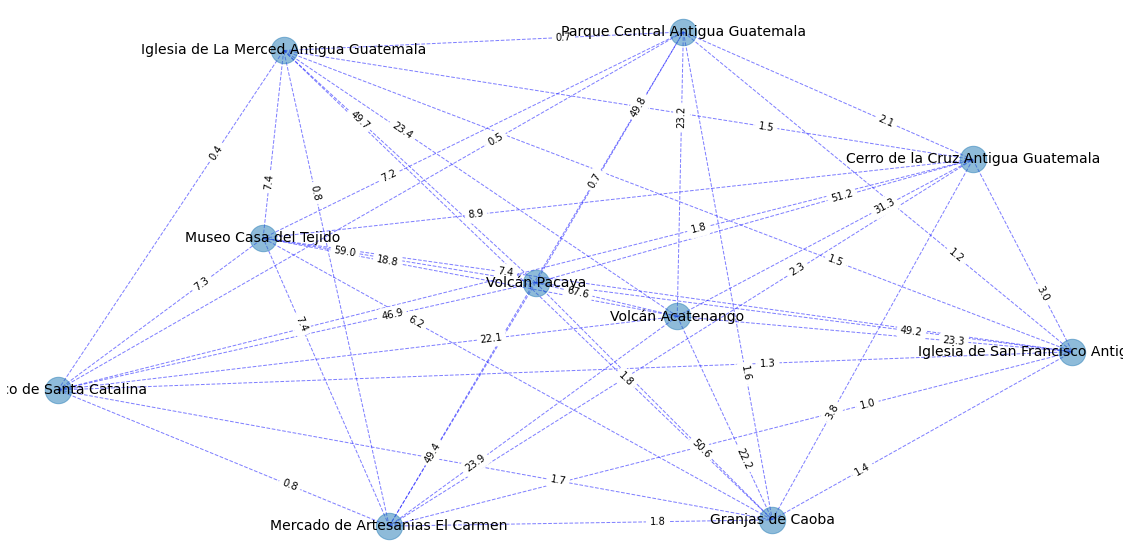

In [ ]:
plt.figure(figsize = (20,10))
G = nx.from_numpy_matrix(np.array(c))
G = nx.relabel_nodes(G, {i:places[i] for i in range(len(places))})

pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700, alpha=0.5)

labels = nx.get_edge_attributes(G,'weight')

# edges
nx.draw_networkx_edges(
    G, pos, width=1.0, alpha=0.5, edge_color="b", style="dashed"
)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,label_pos=0.3)

# labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

plt.axis("off")
plt.show()

## Optimize the route, eliminating places which are not of interest and satisfy budget and time available

### No constraint on time, budget or kind of route - the result should be all the touristic points selected

In [ ]:
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':np.inf,
                    # t_tot is the total available time of the tourist
                    'time_available':np.inf,
                    # preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places preferred (minimum) number of places to visit
                    'num_places': 0
}

In [ ]:
solution, tree, edge_list = optimize_route(parameters_problem, parameters_tourist, prunning=False, best_first_search=False, verbose=True)

selected places to visit: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
level of satisfaction: 46.3
money spent: 120.53999999999999
time spent: 16.8


In [ ]:
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))

depth =  0
n nodes =  1


In [ ]:
[places[x] for x in solution['selected']]

['El Arco de Santa Catalina',
 'Volcán Acatenango',
 'Volcán Pacaya',
 'Mercado de Artesanias El Carmen',
 'Iglesia de La Merced Antigua Guatemala',
 'Parque Central Antigua Guatemala',
 'Cerro de la Cruz Antigua Guatemala',
 'Iglesia de San Francisco Antigua Guatemala',
 'Granjas de Caoba',
 'Museo Casa del Tejido']

### Constrain the budget

In [ ]:
# NO HEURISTICS
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':30,
                    # t_tot is the total available time of the tourist
                    'time_available':np.inf,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 0
}

solution, tree, edge_list_simple = optimize_route(parameters_problem, parameters_tourist, prunning= False, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
solution, tree, edge_list_prunning = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
solution, tree, edge_list_bfs = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=True, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))

selected places to visit: [0, 3, 4, 5, 6, 7, 8, 9]
level of satisfaction: 37.2
money spent: 14.799999999999999
time spent: 9.8
depth =  4
n nodes =  7
--------------------
selected places to visit: [0, 3, 4, 5, 6, 7, 8, 9]
level of satisfaction: 37.2
money spent: 14.799999999999999
time spent: 9.8
depth =  2
n nodes =  5
--------------------
selected places to visit: [0, 3, 4, 5, 6, 7, 8, 9]
level of satisfaction: 37.2
money spent: 14.799999999999999
time spent: 9.8
depth =  1
n nodes =  4


In [ ]:
[places[x] for x in solution['selected']]

['El Arco de Santa Catalina',
 'Mercado de Artesanias El Carmen',
 'Iglesia de La Merced Antigua Guatemala',
 'Parque Central Antigua Guatemala',
 'Cerro de la Cruz Antigua Guatemala',
 'Iglesia de San Francisco Antigua Guatemala',
 'Granjas de Caoba',
 'Museo Casa del Tejido']

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
G1 = nx.Graph()
G1.add_edges_from(edge_list_simple)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.subplot(2,2,2)
G1 = nx.Graph()
G1.add_edges_from(edge_list_prunning)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.subplot(2,2,3)
G1 = nx.Graph()
G1.add_edges_from(edge_list_bfs)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.show()

In [ ]:
from tqdm import tqdm
exec_time_simple = []
for i in tqdm(range(100)):
    start = time.time()
    solution, tree, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= False, best_first_search=False, verbose = False)
    end = time.time()
    exec_time_simple.append(end-start)

print('Simple complete')
exec_time_prunning = []
for i in tqdm(range(100)):
    start = time.time()
    solution, tree, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=False, verbose = False)
    end = time.time()
    exec_time_prunning.append(end-start)

print('Prune complete')
exec_time_bfs = []
for i in tqdm(range(100)):
    start = time.time()
    solution, tree, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=True, verbose = False)
    end = time.time()
    exec_time_bfs.append(end-start)

In [ ]:
df = pd.DataFrame({'no heuristics': exec_time_simple, 'prunning': exec_time_prunning, 'bfs': exec_time_bfs})
 
# Method 1: on the same Axis
plt.figure(figsize=(10,5))
sns.distplot( df["no heuristics"] , color="blue", label="Sin heuristica")
sns.distplot( df["prunning"] , color="red", label="Poda")
sns.distplot( df["bfs"] , color="green", label="Poda + Best-first search")
plt.legend()
plt.xlabel('Tiempo de ejecución (s)')
plt.ylabel('Frecuencia')

print(df.describe())


In [ ]:
budgets = np.linspace(0,100,5)

results = {'budget':[],
              'number nodes simple':[], 'number nodes prunning':[], 'number nodes BFS':[],
              'depth simple':[], 'depth prunning':[], 'depth BFS':[]}

for budget in budgets:
    parameters_tourist['budget'] = budget
    solution,tree_simple, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= False, best_first_search=False, verbose=False)
    solution,tree_prunning, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=False, verbose=False)
    solution,tree_bfs, built_nodes = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=True, verbose=False)
    
    results['budget'].append(budget)
    results['number nodes simple'].append(len(tree_simple))
    results['number nodes prunning'].append(len(tree_prunning))
    results['number nodes BFS'].append(len(tree_bfs))

    results['depth simple'].append(tree_simple[-1]['depth'])
    results['depth prunning'].append(tree_prunning[-1]['depth'])
    results['depth BFS'].append(tree_bfs[-1]['depth'])

pd.DataFrame(results)




### All constraints except preference on kind



In [ ]:
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':80,
                    # t_tot is the total available time of the tourist
                    'time_available':7,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 0
}

solution, tree, edge_list_simple = optimize_route(parameters_problem, parameters_tourist, prunning= False, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
solution, tree, edge_list_prunning = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
solution, tree, edge_list_bfs = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=True, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))

selected places to visit: [0, 2, 3, 4, 6, 7, 9]
level of satisfaction: 32.6
money spent: 32.17
time spent: 7.0
depth =  10
n nodes =  72
--------------------
selected places to visit: [0, 2, 3, 4, 6, 7, 9]
level of satisfaction: 32.6
money spent: 32.17
time spent: 7.0
depth =  3
n nodes =  7
--------------------
selected places to visit: [0, 2, 3, 4, 6, 7, 9]
level of satisfaction: 32.6
money spent: 32.17
time spent: 7.0
depth =  3
n nodes =  7


In [ ]:
[places[x] for x in solution['selected']]

['El Arco de Santa Catalina',
 'Volcán Pacaya',
 'Mercado de Artesanias El Carmen',
 'Iglesia de La Merced Antigua Guatemala',
 'Cerro de la Cruz Antigua Guatemala',
 'Iglesia de San Francisco Antigua Guatemala',
 'Museo Casa del Tejido']

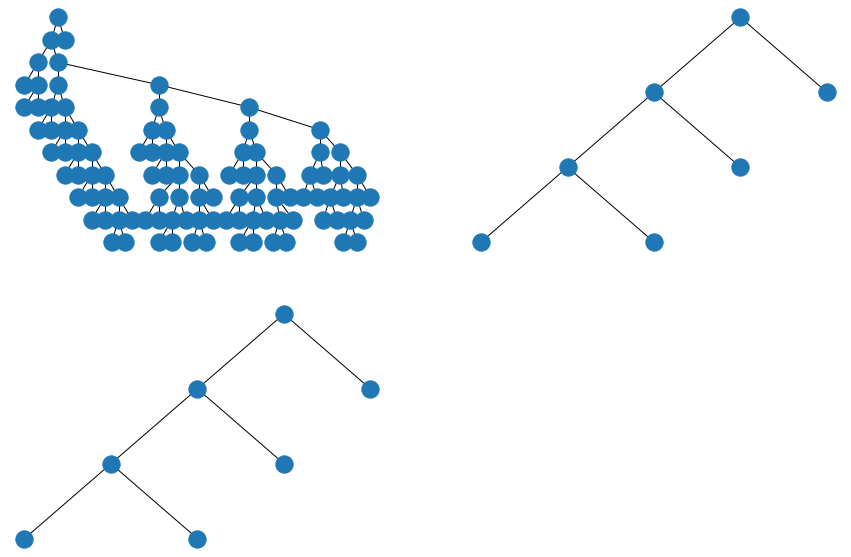

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
G1 = nx.Graph()
G1.add_edges_from(edge_list_simple)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.subplot(2,2,2)
G1 = nx.Graph()
G1.add_edges_from(edge_list_prunning)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.subplot(2,2,3)
G1 = nx.Graph()
G1.add_edges_from(edge_list_bfs)
pos = graphviz_layout(G1, prog="dot")
nx.draw(G1, pos)

plt.show()

### All constraints plus preference on kind



In [ ]:
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':80,
                    # t_tot is the total available time of the tourist
                    'time_available':7,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': 0,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 0
}

solution, tree, edge_list_simple = optimize_route(parameters_problem, parameters_tourist, prunning= False, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
solution, tree, edge_list_prunning = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=False, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))
print('-'*20)
solution, tree, edge_list_bfs = optimize_route(parameters_problem, parameters_tourist, prunning= True, best_first_search=True, verbose = True)
print('depth = ', tree[-1]['depth'])
print('n nodes = ', len(tree))

ValueError: ignored

In [ ]:
[places[x] for x in solution['selected']]